In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Smith-Hutton Problem

We want to solve the following PDE:

\begin{equation}
    u \frac{\partial \phi}{\partial x} + v \frac{\partial \phi}{\partial y} = \Gamma (\phi_{xx} + \phi_{yy}) 
\end{equation}

The independen variables, $x$ and $y$, and the diffusive constant, $\Gamma$, are used as input values for the NN, and the solution (i.e. $\phi(x,y)$) is the output. In order to find the solution, at each step the NN outputs are derived w.r.t the inputs to obtain the first order derivatives. The same is done for the gradients to obtain the second order derivatives. Then, a loss function that matches the PDE is built and the weights are updated accordingly. A loss function that matches the PDE is then used for optimization. If the loss function goes to zero, we can assume that our NN is indeed the solution to our PDE. We will try to find a general solution for different values of $\Gamma$, so we can then obtain a solution for different diffusivities without requiring new computations. The geometry of the problem is as follows:

![sh](pics/sh.png)

In [2]:
#imports

import numpy as np 
import matplotlib.pyplot as plt 
import torch
import nangs
import math 

device = "cuda" if torch.cuda.is_available() else "cpu"

nangs.__version__, torch.__version__

('2021.12.05', '1.10.0')

In [3]:
from nangs import PDE

# velocity field
vel = lambda x, y: (2*y*(1-x**2), -2*x*(1-y**2))

class SH(PDE):
    def computePDELoss(self, inputs, outputs):
                
        # compute first-order derivatives
        grads = self.computeGrads(outputs, inputs)       
        dpdx, dpdy = grads[:, 0], grads[:, 1]
        
        # compute second-order derivatives
        grads2 = self.computeGrads(dpdx, inputs) 
        dp2dx2 = grads2[:, 0]
        
        grads2 = self.computeGrads(dpdy, inputs)
        dp2dy2 = grads2[:, 1]
        
        # compute loss
        x, y, g = inputs[:, 0], inputs[:, 1],inputs[:, 2]
        u, v = vel(x, y)
        return {'pde': u*dpdx + v*dpdy - g*(dp2dx2 + dp2dy2)}


# instanciate pde
pde = SH(inputs=('x', 'y', 'g'), outputs='p')

In [4]:
# define the sampler

from nangs import RandomSampler

sampler = RandomSampler({
    'x': [-1., 1.], 
    'y': [0., 1.],
    'g': [1e-6, 1e-1]
}, device=device, n_samples=1000)

pde.set_sampler(sampler)

In [5]:
# boundary conditions

from nangs import Dirichlet

ALPHA = 10

n_samples = 1000
left = Dirichlet(
    RandomSampler({'x': -1, 'y': [0., 1.], 'g': [1e-6, 1e-1]}, device=device, n_samples=n_samples), 
    lambda inputs: {'p' : torch.ones(n_samples, device=inputs['x'].device)*(1. - math.tanh(ALPHA))},
    name="left"
)

pde.add_boco(left)

In [6]:
right = Dirichlet(
    RandomSampler({'x': 1, 'y': [0., 1.], 'g': [1e-6, 1e-1]}, device=device, n_samples=n_samples), 
    lambda inputs: {'p' : torch.ones(n_samples, device=inputs['x'].device)*(1. - math.tanh(ALPHA))},
    name="right"
)

pde.add_boco(right)

In [7]:
# top b.c 

top = Dirichlet(
    RandomSampler({'x': [-1., 1.], 'y': 1., 'g': [1e-6, 1e-1]}, device=device, n_samples=n_samples), 
    lambda inputs: {'p' : torch.ones(n_samples, device=inputs['x'].device)*(1. - math.tanh(ALPHA))},
    name="top"
)

pde.add_boco(top)

In [8]:
# bottom b.c

bot_left = Dirichlet(
    RandomSampler({'x': [-1., 0.], 'y': 0., 'g': [1e-6, 1e-1]}, device=device, n_samples=n_samples), 
    lambda inputs: {'p' : 1. + torch.tanh(ALPHA*(2*inputs['x']+1))},
    name="bot-left"
)

pde.add_boco(bot_left)

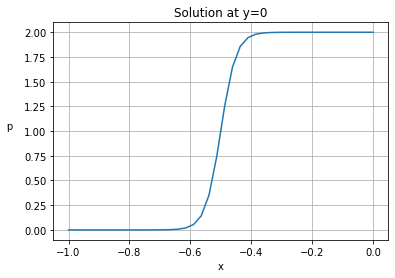

In [9]:
x1 = np.linspace(-1, 0, 40)
p1 = 1. + np.tanh(ALPHA*(2.*x1 + 1.))

plt.plot(x1, p1)
plt.xlabel('x')
plt.ylabel('p      ', rotation=np.pi/2)
plt.title('Solution at y=0')
plt.grid()
plt.show()

In [10]:
# bottom right b.c

from nangs import Neumann

class MyNeumann(Neumann):
    def computeBocoLoss(self, inputs, outputs):
        dpdy = self.computeGrads(outputs, inputs)[:, 1]
        return {'gradY': dpdy}

bot_right = MyNeumann(
    RandomSampler({'x': [0., 1.], 'y': 0., 'g': [1e-6, 1e-1]}, device=device, n_samples=n_samples), 
    name='bot-right'
)

pde.add_boco(bot_right)

In [11]:
# solve

from nangs import MLP

LR = 1e-3
N_STEPS = 5000
NUM_LAYERS = 5
NUM_HIDDEN = 256

mlp = MLP(len(pde.inputs), len(pde.outputs), NUM_LAYERS, NUM_HIDDEN).to(device)
optimizer = torch.optim.Adam(mlp.parameters())
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LR, pct_start=0.1, div_factor=10, final_div_factor=1, total_steps=N_STEPS)

pde.compile(mlp, optimizer, scheduler)
%time hist = pde.solve(N_STEPS)

{'pde': 0.00161, 'left': 1e-05, 'right': 2e-05, 'top': 1e-05, 'bot-left': 0.00294, 'bot-right_gradY': 0.0004}: 100%|██████████| 5000/5000 [01:05<00:00, 76.70it/s]

CPU times: user 1min 4s, sys: 622 ms, total: 1min 5s
Wall time: 1min 5s


<AxesSubplot:>

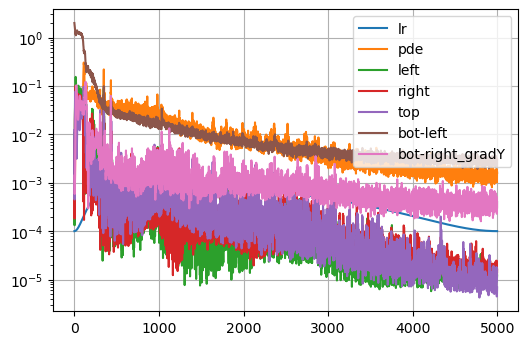

In [12]:
import pandas as pd 

df = pd.DataFrame(hist)
fig = plt.figure(dpi=100)
ax = plt.subplot(1,1,1)
ax.set_yscale('log')
df.plot(ax=ax, grid=True)

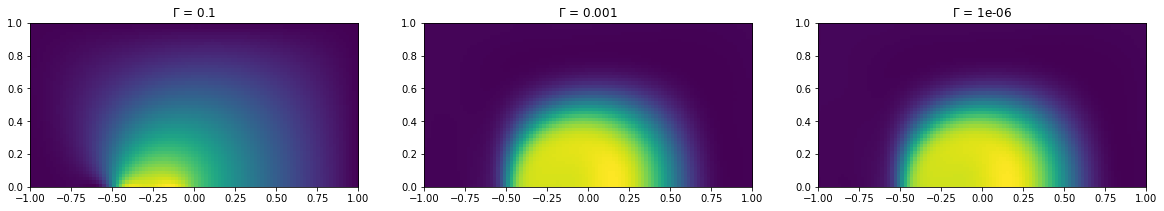

In [13]:
# evaluate the solution
#pde.load_state_dict('best.pth')

x = np.linspace(-1,1,100)
y = np.linspace(0,1,50)
g = np.array([0.1, 0.001, 0.000001])

grid = np.stack(np.meshgrid(x, y, g), -1).reshape(-1, 3)
X = torch.from_numpy(grid).float().to(device)
p = pde.eval(X).cpu().view(len(x),len(y),len(g)).numpy()

fig, axs = plt.subplots(1, len(g), figsize=(20,20*len(g)))
for i, ax in enumerate(axs):
    _p = p[...,i].reshape((len(y),len(x)))
    axs[i].imshow(_p, vmin=_p.min(), vmax=_p.max(), origin='lower',
               extent=[x.min(), x.max(), y.min(), y.max()])
    axs[i].set_title(f"$\\Gamma$ = {g[i]}")

plt.show()

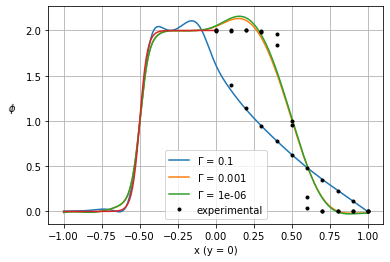

In [14]:
# experimental results

exp = {
    'x': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'g_0.1': [1.989,1.402,1.146,0.946,0.775,0.621,0.480,0.349,0.227,0.111,0.0],
    'g_0.001': [2.0000,1.9990,1.9997,1.985,1.841,0.951,0.154,0.001,0.0,0.0,0.0],
    'g_0.000001': [2.0000,2.0,2.0,1.999,1.964,1.0,0.036,0.001,0.0,0.0,0.0]
}

x = np.linspace(-1,1,200)
y = np.array([0])
g = np.array([0.1, 0.001, 0.000001])

grid = np.stack(np.meshgrid(x, y, g), -1).reshape(-1, 3)
X = torch.from_numpy(grid).float().to(device)

p = pde.eval(X).cpu().numpy().reshape(len(x), len(g))

for i in range(len(g)):
    plt.plot(x, p[:,i], label=f"$\\Gamma$ = {g[i]}")

p1 = 1. + np.tanh(ALPHA*(2*x[x<0]+1))
plt.plot(x[x<0], p1)

plt.plot(exp['x'], exp['g_0.1'], '.k')
plt.plot(exp['x'], exp['g_0.001'], '.k')
plt.plot(exp['x'], exp['g_0.000001'], '.k', label="experimental")
plt.grid()
plt.xlabel('x (y = 0)')
plt.ylabel('$\\phi$       ', rotation=np.pi/2)
plt.legend()
plt.show()